# GradCAM Visualization Demo with ResNet101

Requirement:

* GPU Memory: 6GB or higher


In [1]:
# Replace vanila relu to guided relu to get guided backpropagation.
import tensorflow as tf

from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops._relu_grad(grad, op.outputs[0]), tf.zeros(grad.get_shape()))

/home1/work/insikk/tf1.2/lib/python3.4/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


INFO:tensorflow:Restoring parameters from model/resnet_v1_101.ckpt
Top1:  n02108422 bull mastiff 0.852247
Top5:  [('n02108422 bull mastiff', 0.85224706), ('n02108089 boxer', 0.10227389), ('n02109047 Great Dane', 0.0089409566), ('n02109525 Saint Bernard, St Bernard', 0.0089075351), ('n02123159 tiger cat', 0.0088995025)]
grads_val shape: (7, 7, 2048)
gb_viz shape: (224, 224, 3)


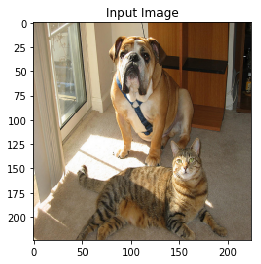

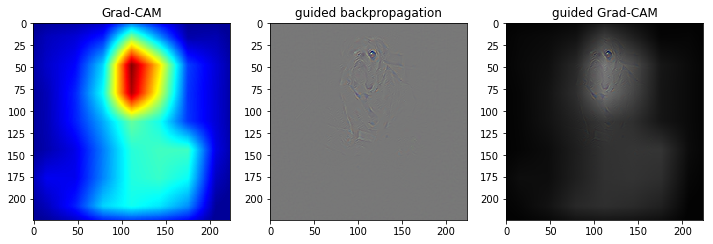

Top1:  n02086240 Shih-Tzu 0.601508
Top5:  [('n02086240 Shih-Tzu', 0.60150778), ('n02086079 Pekinese, Pekingese, Peke', 0.19358583), ('n02085782 Japanese spaniel', 0.10067803), ('n02098413 Lhasa, Lhasa apso', 0.040157557), ('n02086646 Blenheim spaniel', 0.028739054)]
grads_val shape: (7, 7, 2048)
gb_viz shape: (224, 224, 3)


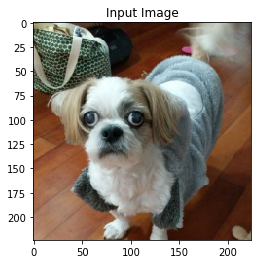

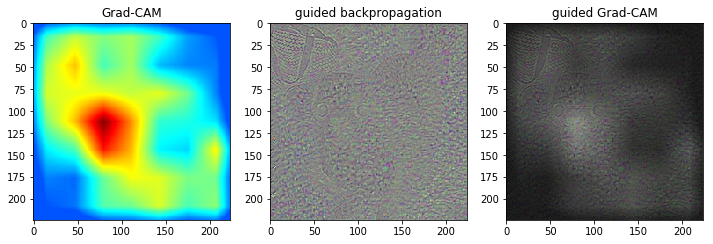

Top1:  n02129604 tiger, Panthera tigris 0.886261
Top5:  [('n02129604 tiger, Panthera tigris', 0.88626087), ('n02123159 tiger cat', 0.099186532), ('n02128925 jaguar, panther, Panthera onca, Felis onca', 0.0028913401), ('n02127052 lynx, catamount', 0.00089701696), ('n02391049 zebra', 0.00048119816)]
grads_val shape: (7, 7, 2048)
gb_viz shape: (224, 224, 3)


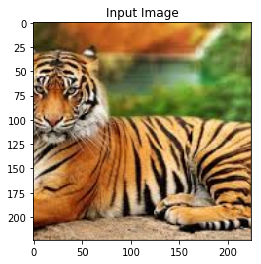

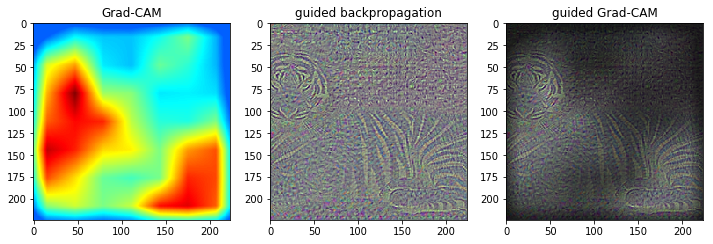

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

from nets import resnet_v1
slim = tf.contrib.slim


import utils

# Create mini-batch for demo

img1 = utils.load_image("./demo.png", normalize=False)
img2 = utils.load_image("./shihtzu_mypuppy.jpg", normalize=False)
img3 = utils.load_image("./tiger.jpg", normalize=False)

batch1_img = img1.reshape((1, 224, 224, 3))
batch1_label = np.array([1 if i == 242 else 0 for i in range(1000)])  # 1-hot result for Boxer
batch1_label = batch1_label.reshape(1, -1)

batch2_img = img2.reshape((1, 224, 224, 3))
batch2_label = np.array([1 if i == 155 else 0 for i in range(1000)])  # 1-hot result for Shih-Tzu
batch2_label = batch2_label.reshape(1, -1)

batch3_img = img3.reshape((1, 224, 224, 3))
batch3_label = np.array([1 if i == 292 else 0 for i in range(1000)])  # 1-hot result for tiger
batch3_label = batch3_label.reshape(1, -1)

batch_img = np.concatenate((batch1_img, batch2_img, batch3_img), 0)
batch_label = np.concatenate((batch1_label, batch2_label, batch3_label), 0)
batch_size = 3

# batch_img = np.concatenate((batch1_img), 0)
# batch_label = np.concatenate((batch1_label), 0)
# batch_size = 1
# batch_label = batch_label.reshape(batch_size, -1)

# Create tensorflow graph for evaluation
eval_graph = tf.Graph()
with eval_graph.as_default():
    with eval_graph.gradient_override_map({'Relu': 'GuidedRelu'}):
        images = tf.placeholder("float", [batch_size, 224, 224, 3])
        labels = tf.placeholder(tf.float32, [batch_size, 1000])
        train_mode = tf.placeholder(tf.bool)
        
        preprocessed_images = utils.resnet_preprocess(images)
        
        with slim.arg_scope(resnet_v1.resnet_arg_scope()):
            net, end_points = resnet_v1.resnet_v1_101(preprocessed_images, 1000, is_training=train_mode)
        prob = end_points['predictions'] # after softmax
        
        # sess_config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.OFF
        cost = tf.reduce_sum((prob - labels) ** 2)
        train = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)

        # Get last convolutional layer gradient for generating gradCAM visualization
        # print('endpoints:', end_points.keys())
        target_conv_layer = end_points['resnet_v1_101/block4/unit_2/bottleneck_v1']
        # target_conv_layer = end_points['resnet_v1_50/block3/unit_5/bottleneck_v1']
        target_conv_layer_grad = tf.gradients(cost, target_conv_layer)[0]

        # Guided backpropagtion back to input layer
        gb_grad = tf.gradients(cost, images)[0]

        # Normalizing the gradients    
        target_conv_layer_grad_norm = tf.div(target_conv_layer_grad, tf.sqrt(tf.reduce_mean(tf.square(target_conv_layer_grad))) + tf.constant(1e-5))


        init = tf.global_variables_initializer()
        
        # Load resnet v1 weights
        
        # latest_checkpoint = tf.train.latest_checkpoint("model/resnet_v1_50.ckpt")
        latest_checkpoint = "model/resnet_v1_101.ckpt"
        ## Optimistic restore.
        reader = tf.train.NewCheckpointReader(latest_checkpoint)
        saved_shapes = reader.get_variable_to_shape_map()
        variables_to_restore = tf.global_variables()
        for var in variables_to_restore:
          if not var.name.split(':')[0] in saved_shapes:
            print("WARNING. Saved weight not exists in checkpoint. Init var:", var.name)
          else:
            # print("Load saved weight:", var.name)
            pass

        var_names = sorted([(var.name, var.name.split(':')[0]) for var in variables_to_restore
                if var.name.split(':')[0] in saved_shapes])
        restore_vars = []
        with tf.variable_scope('', reuse=True):
            for var_name, saved_var_name in var_names:
                try:
                    curr_var = tf.get_variable(saved_var_name)
                    var_shape = curr_var.get_shape().as_list()
                    if var_shape == saved_shapes[saved_var_name]:
                        # print("restore var:", saved_var_name)
                        restore_vars.append(curr_var)
                except ValueError:
                    print("Ignore due to ValueError on getting var:", saved_var_name) 
        saver = tf.train.Saver(restore_vars)
        
        
        
# Run tensorflow 

with tf.Session(graph=eval_graph) as sess:    
    sess.run(init)    
    # sess.run(tf.local_variables_initializer())
    saver.restore(sess, latest_checkpoint)
    
    prob = sess.run(prob, feed_dict={images: batch_img, train_mode: False})  
    
    gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad_norm], feed_dict={images: batch_img, labels: prob, train_mode: True})
    # gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad_norm], feed_dict={images: batch_img, labels: label, train_mode: True})
    
    
    for i in range(batch_size):
        # print('See visualization of below category')
        # utils.print_prob(batch_label[i], './synset.txt')
        utils.print_prob(prob[i], './synset.txt')
        # print('gb_grad_value[i]:', gb_grad_value[i])
        # print('gb_grad_value[i] shape:', gb_grad_value[i].shape)
        utils.visualize(batch_img[i], target_conv_layer_value[i], target_conv_layer_grad_value[i], gb_grad_value[i])
    